<div style="text-align: right;">
Adrián Rubio Castillo
</div>

# SERIES TEMPORALES

### Introducción

En este proyecto se realizarán predicciones mediante diferentes métodos de series temporales, con el objetivo de predecir en nuestro caso, la cantidad de acciones negociadas de NVIDIA. Los datos que utilizaremos se encuentran en:
https://www.kaggle.com/code/joshuabaliliongcoy/nvidia-stock-prediction-with-time-series-analysis/input

El dataset contiene:
- Date: Fecha del stock entrante.
- Open: Precio de apertura de la acción.
- High: Precio máximo de stock del día.
- Low: Precio mínimo de stock del dia.
- Close: Precio de cierre de la acción.
- Volume: Nñumero total de acciones negociadas.

El objetivo de este proyecto es estudiar el comportamiento y predecir la cantidad de acciones de NVIDIA en el futuro.

In [1]:
#Importamos las librerías necesarias
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from io import StringIO
import contextlib
import re

# pmdarima
# !pip install pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima

# statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# skforecast
#!pip install skforecast
from skforecast.Sarimax import Sarimax
#from skforecast.ForecasterSarimax import ForecasterSarimax
#from skforecast.model_selection_sarimax import backtesting_sarimax
#from skforecast.model_selection_sarimax import grid_search_sarimax
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
import warnings

In [2]:
# Importamos nuestro conjuto de datos
nvd = pd.read_csv("C:/Users/adria/Desktop/Master Data Science & IA/Mineria de datos & Modelizacion predictiva/3. Series temporales/Datos_tarea/NVDA.csv")

In [3]:
nvd.head()

,Date,Adj Close,Close,High,Low,Open,Volume
0,1999-01-22,0.037615,0.041016,0.048828,0.038802,0.043750,2714688000
1,1999-01-25,0.041556,0.045313,0.045833,0.041016,0.044271,510480000
2,1999-01-26,0.038331,0.041797,0.046745,0.041146,0.045833,343200000
3,1999-01-27,0.038212,0.041667,0.042969,0.039583,0.041927,244368000
4,1999-01-28,0.038092,0.041536,0.041927,0.041276,0.041667,227520000


Ajustar el formato de la fecha a nuestro índice de nuestro dataset
y nos quedamos con la variable sobre la que deseamos hacer el estudio: "Volume"

In [4]:
nvd = nvd[["Date", "Volume"]]
nvd['Date']=pd.to_datetime(nvd['Date'])  # format='%YM%m')
nvd.index = nvd["Date"]
del nvd["Date"]
# Previsualizamos nuestros datos
nvd

,Volume
Date,
1999-01-22,2714688000
1999-01-25,510480000
1999-01-26,343200000
1999-01-27,244368000
1999-01-28,227520000
...,...
2025-02-10,216989100
2025-02-11,178902400
2025-02-12,160278600


Observamos que nuestros datos tiene una distribución de fechas irregular, en nuestro caso nos interesa los datos del primer dia del mes

In [5]:
nvd[nvd.index.day == 1].head()

#nvd_orig = nvd[nvd.in10dex.day == 1]
#nvd[100:105]

,Volume
Date,
1999-02-01,154704000
1999-03-01,92160000
1999-04-01,30432000
1999-06-01,98544000
1999-07-01,88992000


Podemos ver como hay meses donde no hay datos para el dia 1 como se puede apreciar en Mayo de 1999, para solucionar esto hará valta imputarlos con la función resample, indicando la frecuencia de nuestros datos, el cual será el inicio de cada mes.

Posteriormente comprobamos la cantidad de datos nulos que pueda haber en nuestros datos

In [6]:
nvd = nvd.resample('MS').first()

print(nvd.isna().sum())

Volume    0
dtype: int64


Vemos como no hay datos nulos, seguidamente realizamos un gráfico para visualizar nuestros datos.

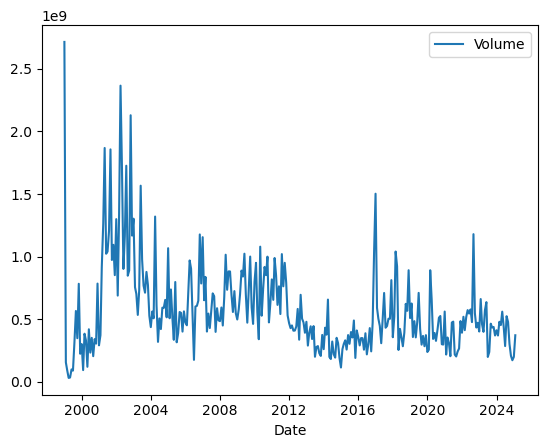

Se observa que la serie no es estacionaria, pues la media fluctua, y tampoco presenta varianza homocedástica. 

El tratamiento adecuado seria aplicar el logaritmo para eliminar la heterocedasticidad 
y diferenciarla en orden d para buscar la estacionariedad en media

Igualmente, parece observarse un comportamiento estacional a lo largo de la serie


In [7]:
sns.lineplot(nvd)
plt.show()
print("Se observa que la serie no es estacionaria, pues la media fluctua, y tampoco presenta varianza homocedástica. \n\nEl tratamiento adecuado seria aplicar el logaritmo para eliminar la heterocedasticidad \ny diferenciarla en orden d para buscar la estacionariedad en media")
print("\nIgualmente, parece observarse un comportamiento estacional a lo largo de la serie")

Descompondremos la serie temporal:

In [8]:
# Realizar la descomposición estacional multiplicativo ya que la varianza no es homocedástica, 
# pero usaremos los dos métodos para observarlos igualmente
nvd_de_mult = seasonal_decompose(nvd, model='multiplicative') 
nvd_de_addi = seasonal_decompose(nvd, model='additive') 

In [9]:
# Multiplicativo
print(f'El mes con menor coeficiente es: {nvd_de_mult.seasonal.idxmin(),nvd_de_mult.seasonal.min()}')
print(f'El mes con mayor coeficiente es: {nvd_de_mult.seasonal.idxmax(),nvd_de_mult.seasonal.max()}')

# Aditivo
print(f'\nEl mes con menor coeficiente es: {nvd_de_addi.seasonal.idxmin(),nvd_de_addi.seasonal.min()}')
print(f'El mes con mayor coeficiente es: {nvd_de_addi.seasonal.idxmax(),nvd_de_addi.seasonal.max()}')

El mes con menor coeficiente es: (Timestamp('1999-02-01 00:00:00'), 0.8665044807728943)
El mes con mayor coeficiente es: (Timestamp('1999-04-01 00:00:00'), 1.1562523222495318)

El mes con menor coeficiente es: (Timestamp('1999-02-01 00:00:00'), -90787068.3840812)
El mes con mayor coeficiente es: (Timestamp('1999-04-01 00:00:00'), 89727046.61591882)


In [10]:
print(nvd_de_mult.seasonal)

print("\nEn Febrero de 2025 la cantidad de acciones de NVIDIA bajaro un 13.35% respecto a la media global")

Date
1999-01-01    1.011760
1999-02-01    0.866504
1999-03-01    1.069839
1999-04-01    1.156252
1999-05-01    0.958690
                ...   
2024-10-01    1.004022
2024-11-01    1.016489
2024-12-01    0.996716
2025-01-01    1.011760
2025-02-01    0.866504
Freq: MS, Name: seasonal, Length: 314, dtype: float64

En Febrero de 2025 la cantidad de acciones de NVIDIA bajaro un 13.35% respecto a la media global


In [11]:
print(nvd_de_addi.seasonal)

print("\nEn Marzo de 1999 la cantidad de acciones de NVIDIA subieron en 22860880 unidades respecto a la media global")

Date
1999-01-01    1.640578e+07
1999-02-01   -9.078707e+07
1999-03-01    2.286088e+07
1999-04-01    8.972705e+07
1999-05-01    1.817662e+07
                  ...     
2024-10-01   -1.162895e+07
2024-11-01    1.687412e+07
2024-12-01   -1.479900e+07
2025-01-01    1.640578e+07
2025-02-01   -9.078707e+07
Freq: MS, Name: seasonal, Length: 314, dtype: float64

En Marzo de 1999 la cantidad de acciones de NVIDIA subieron en 22860880 unidades respecto a la media global


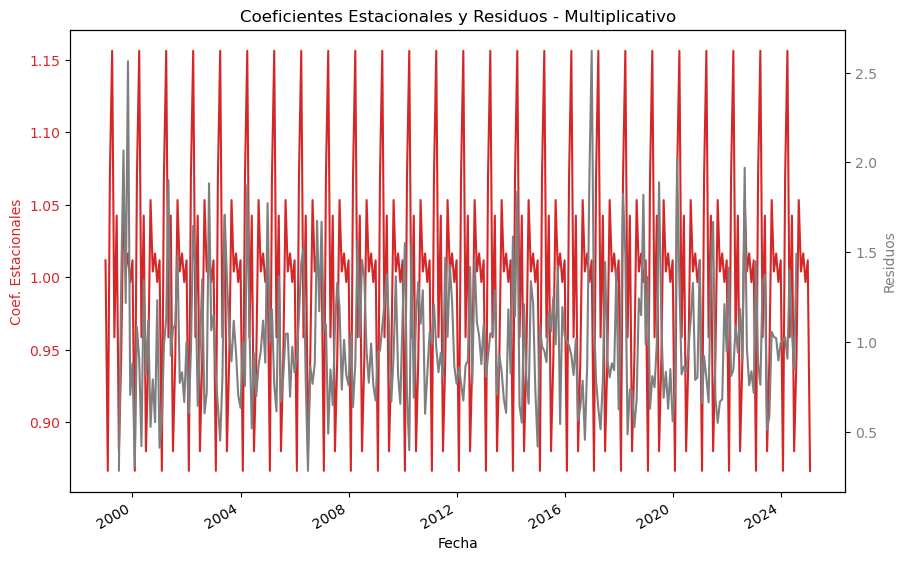

In [12]:
# Crear un gráfico con dos ejes y compartir el eje x -------  MULTIPLICATIVO
fig, ax1 = plt.subplots(figsize=(10,6))

# Primera serie en el eje izquierdo (ax1)
color = 'tab:red'
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Coef. Estacionales', color=color)
ax1.plot(nvd_de_mult.seasonal, color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=30, ha='right')
# Segunda serie en el eje derecho (ax2)
ax2 = ax1.twinx()  # Compartir el eje x
color = 'tab:grey'
ax2.set_ylabel('Residuos', color=color)
ax2.plot(nvd_de_mult.resid, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Ajustes de diseño
plt.title('Coeficientes Estacionales y Residuos - Multiplicativo')
plt.show()

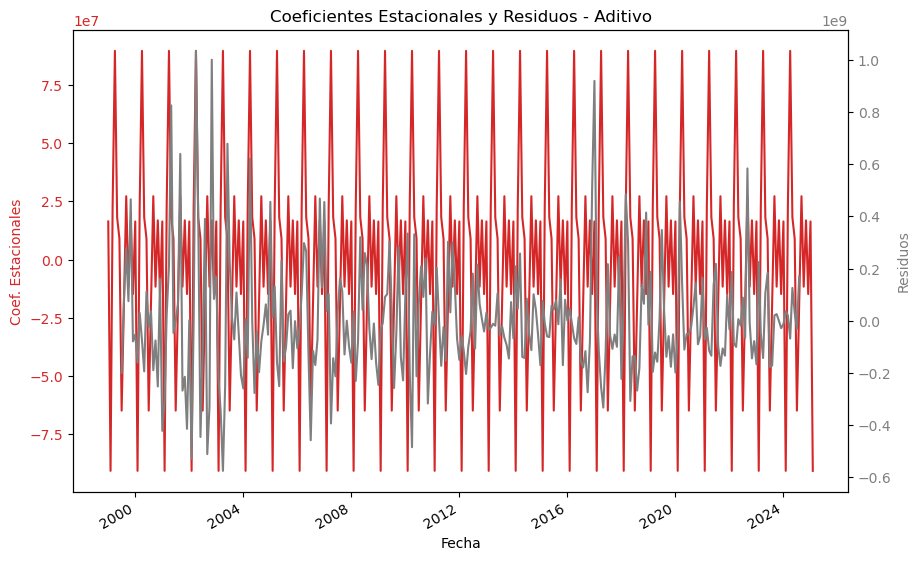

In [13]:
# Crear un gráfico con dos ejes y compartir el eje x -------  ADITIVO
fig, ax1 = plt.subplots(figsize=(10,6))

# Primera serie en el eje izquierdo (ax1)
color = 'tab:red'
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Coef. Estacionales', color=color)
ax1.plot(nvd_de_addi.seasonal, color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=30, ha='right')
# Segunda serie en el eje derecho (ax2)
ax2 = ax1.twinx()  # Compartir el eje x
color = 'tab:grey'
ax2.set_ylabel('Residuos', color=color)
ax2.plot(nvd_de_addi.resid, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Ajustes de diseño
plt.title('Coeficientes Estacionales y Residuos - Aditivo')
plt.show()

Podemos observar como se presenta estacionaliedad tanto en el esquema multilicativo como en el esquema aditivo. En cuanto a los residuos, vemos como en el esquema multiplicativo hay mayor variazión en los años 1999 y 2017; en cambio, en el esquema aditivo se puede obesrvar una variazión más pronunciada de los residuos en los años 2001, 2002, 2003 y 2017.

Para más detalle observaremos cada componente por separado tanto para el esquema multiplicativo como el esquema aditivo.

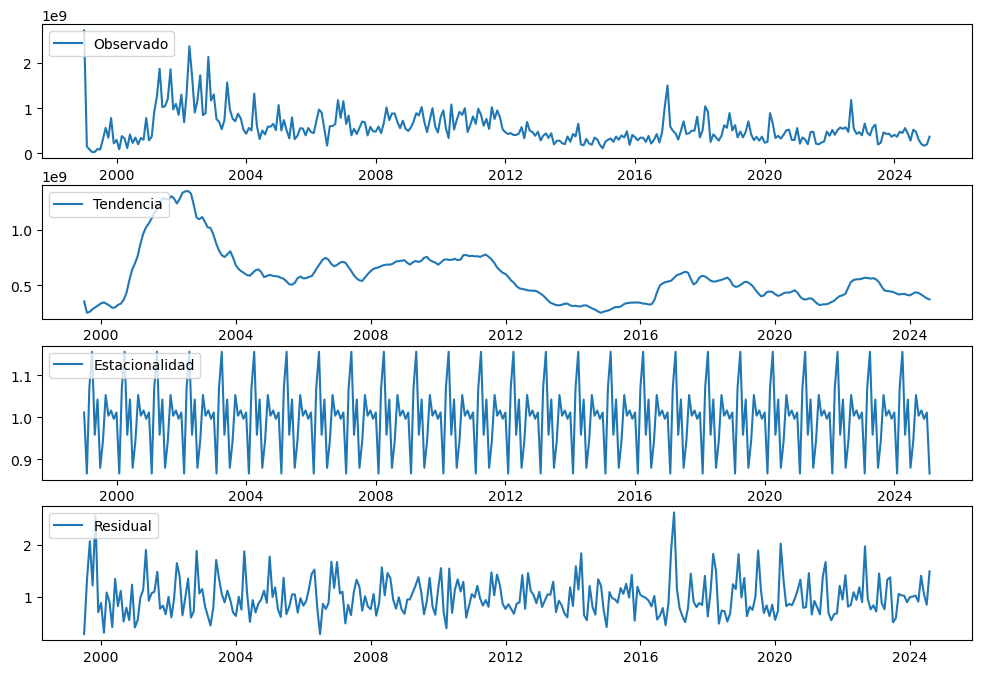

In [14]:
# MULTIPLICATIVO
#al representarlo de la forma anterior, no se obseran las fechas en todos los gráficos, por lo que:
# Visualizar las componentes
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(nvd_de_mult.observed, label='Observado')
plt.legend(loc='upper left')

plt.subplot(4, 1, 2)
plt.plot(nvd_de_mult.trend, label='Tendencia')
plt.legend(loc='upper left')

plt.subplot(4, 1, 3)
plt.plot(nvd_de_mult.seasonal, label='Estacionalidad')
plt.legend(loc='upper left')

plt.subplot(4, 1, 4)
plt.plot(nvd_de_mult.resid, label='Residual')
plt.legend(loc='upper left')

plt.show()

En el esquema multiplicativo podemos observar en los datos observados como hay valores altos en los años 2001, 2002, 2003; debido a la tendencia de la serie. La tendencia de la serie fue ascendente en los años anteriormente comentados, y a lo largo de los próximos años ha ido decreciendo lentamente. Podemos ver como presenta una estacionaliedad clara. Y los residuos son aleatorios y no presentan ningun patrón.

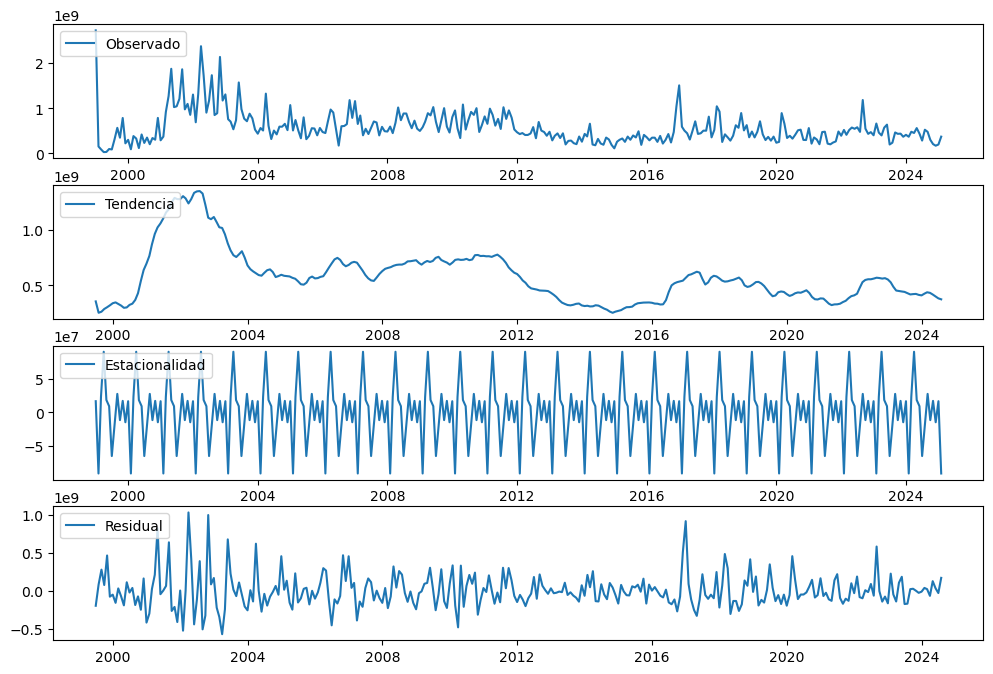

In [15]:
# ADITIVO
#al representarlo de la forma anterior, no se obseran las fechas en todos los gráficos, por lo que:
# Visualizar las componentes
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(nvd_de_addi.observed, label='Observado')
plt.legend(loc='upper left')

plt.subplot(4, 1, 2)
plt.plot(nvd_de_addi.trend, label='Tendencia')
plt.legend(loc='upper left')

plt.subplot(4, 1, 3)
plt.plot(nvd_de_addi.seasonal, label='Estacionalidad')
plt.legend(loc='upper left')

plt.subplot(4, 1, 4)
plt.plot(nvd_de_addi.resid, label='Residual')
plt.legend(loc='upper left')

plt.show()

En el esquema aditivo podemos observar en los datos observados como hay valores altos en los años 2001, 2002, 2003; debido a la tendencia de la serie y a los residuos. La tendencia de la serie fue ascendente en los años anteriormente comentados, y a lo largo de los próximos años ha ido decreciendo lentamente. Podemos ver como presenta una estacionaliedad clara. Y los residuos son aleatorios y no presentan ningun patrón.

Podríamos visualizar que años podrían ser aquellos donde se hayan registrado mayor número de acciones de NVIDIA

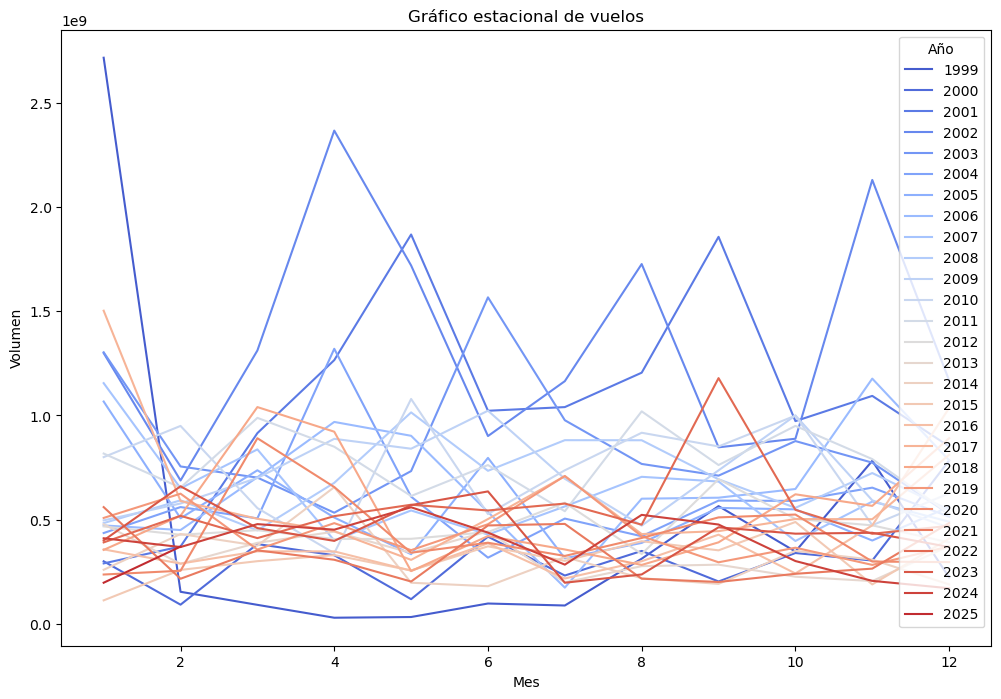

In [16]:
nvd['Año'] = pd.to_datetime(nvd.index, format='%YM%m').year
sns.set_palette("coolwarm", 27)
plt.figure(figsize=(12, 8))
for Año, datos_año in nvd.groupby('Año'):
    plt.plot(datos_año.index.month, datos_año['Volume'], label=str(Año))

# Añadir leyendas y título
plt.legend(title='Año')
plt.title('Gráfico estacional de vuelos')
plt.xlabel('Mes')
plt.ylabel('Volumen')

# Mostrar el gráfico
plt.show()

Podemos apreciar aproximadamente como en los años 2001, 2002 y 2003 son los años donde se registraron mayor número de acciones, lo cual tiene sentido con las conclusiones que anteriormente hemos hecho.

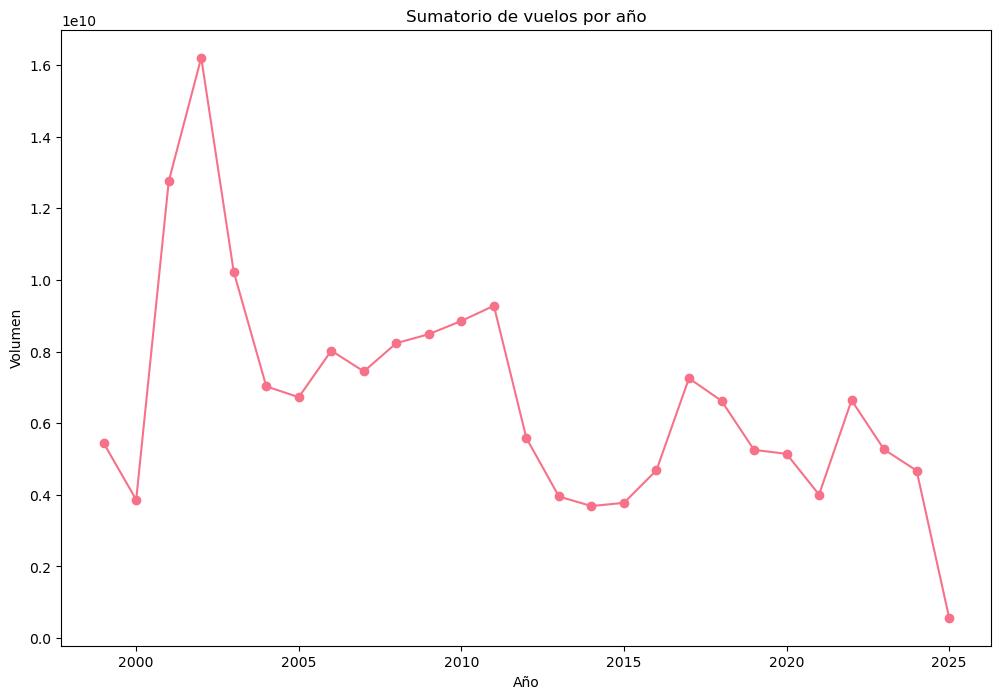

In [17]:
# Obtener el sumatorio por año
sumatorio_por_año = nvd.groupby('Año')['Volume'].sum()

plt.figure(figsize=(12, 8))

# Utilizar la paleta "husl" de Seaborn
sns.set_palette("husl")

# Graficar el sumatorio por año
plt.plot(sumatorio_por_año.index, sumatorio_por_año, marker='o')

# Añadir leyendas y título
plt.title('Sumatorio de vuelos por año')
plt.xlabel('Año')
plt.ylabel('Volumen')

# Mostrar el gráfico
plt.show()

En este gráfico podemos reafirmar nuestras afirmaciones anteriores.

Hacemos una división en nuestros datos, donde dividimos nuestros datos en dos conjuntos: train y test; con el objetivo de hacer predicciones y compararlas con los datos reales que tenemos en nuestros datos.

In [18]:
nvd_train = nvd.loc[:'2024-02-01 00:00:00']
nvd_train

,Volume,Año
Date,,
1999-01-01,2714688000,1999
1999-02-01,154704000,1999
1999-03-01,92160000,1999
1999-04-01,30432000,1999
1999-05-01,33840000,1999
...,...,...
2023-10-01,433298000,2023
2023-11-01,437593000,2023
2023-12-01,369317000,2023


In [19]:
nvd_test = nvd['2024-03-01 00:00:00':]
len(nvd_test)

12

<Axes: xlabel='Date', ylabel='Volume'>

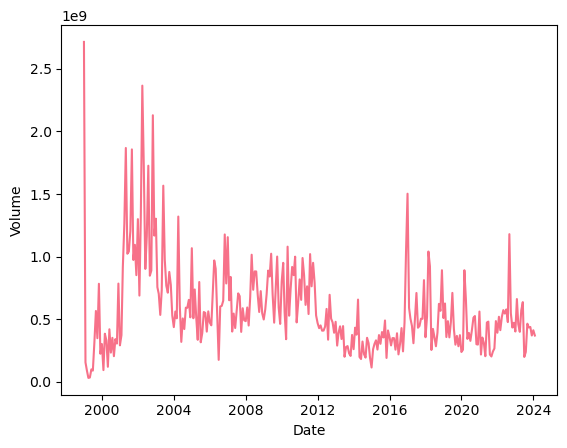

In [20]:
sns.lineplot(nvd_train['Volume'])

Observando que la varianza es homocedástica y que presenta cierta tendencia, transformaremos los datos de train con un logartimo y diferenciaremos la seria posteriormente. Buscando que la serie sea estacionaria en media y varianza.

<Axes: xlabel='Date', ylabel='Volume'>

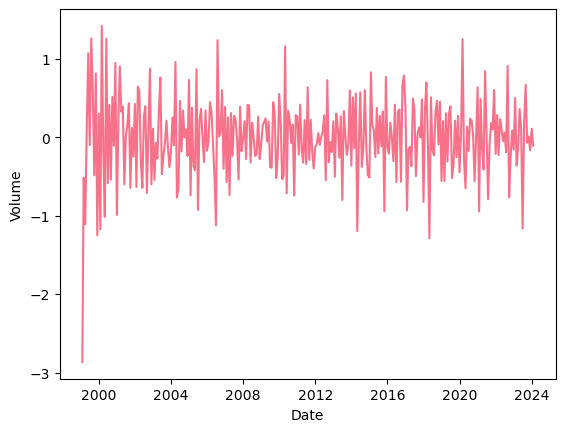

In [21]:
nvdTr_log = np.log(nvd_train['Volume'])
nvdTr_logdiff = nvdTr_log.diff().dropna()

sns.lineplot(nvdTr_logdiff)

Podemos ver como la serie es estacionaria en media, pero no en varianza, aunque la varianza heterocedástica de la serie original ha mejorado notablemente. Utilizaremos estos datos transformados con los siguientes métodos de suavizado.

In [22]:
# Comprobamos que no hay valores nulos
nvdTr_logdiff.isna().sum()

0

A continuación realizaremos predicciones con diferentes métodos de suavizado teniendo en cuenta algunas características:

#### Si el modelo no tiene tendencia ni estacionalidad: alisado simple.
#### Si el modelo tiene tendencia y no tiene estacionalidad: alisado doble.
#### Si el modelo tiene tendencia y estacionalidad: alisado Holt-Winters.

# Modelo Alisado Simple


In [23]:
# Aplicar suavizado Alisado simple.
nvd_train.index.freq = 'MS'
# Aplicar suavizado exponencial simple.
modelo_as = sm.tsa.SimpleExpSmoothing(nvdTr_logdiff, initialization_method="estimated").fit()
# Para seleccionar distintas alphas, fit(smoothing_level=alpha)
# Calcular la predicción para 1 año
predicciones_as = modelo_as.forecast(steps=12)
# Para ver parámetros, e.g.: alpha = 0.995
modelo_as.summary()

Dep. Variable:,Volume,No. Observations:,301
Model:,SimpleExpSmoothing,SSE,79.600
Optimized:,True,AIC,-396.358
Trend:,None,BIC,-388.944
Seasonal:,None,AICC,-396.223
Seasonal Periods:,None,Date:,"Wed, 19 Mar 2025"
Box-Cox:,False,Time:,18:34:30
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.4901e-08,alpha,True
initial_level,-0.0066287,l.0,True


Podemos ver SSE bajo en relación a la serie que estamos trabajando, vemos como 𝛼 tiene un valor de 1.4901e-08 lo que nos dice que el peso que le da a los datos del presente es muy bajo, y un peso muy alto a los valores del pasado. 

Hay que probar con modelos de suavizado más avanzados y comprobar con los criterios AIC, BIC y AICC de los futuros modelos para sabe cual puede ser el más indicado.

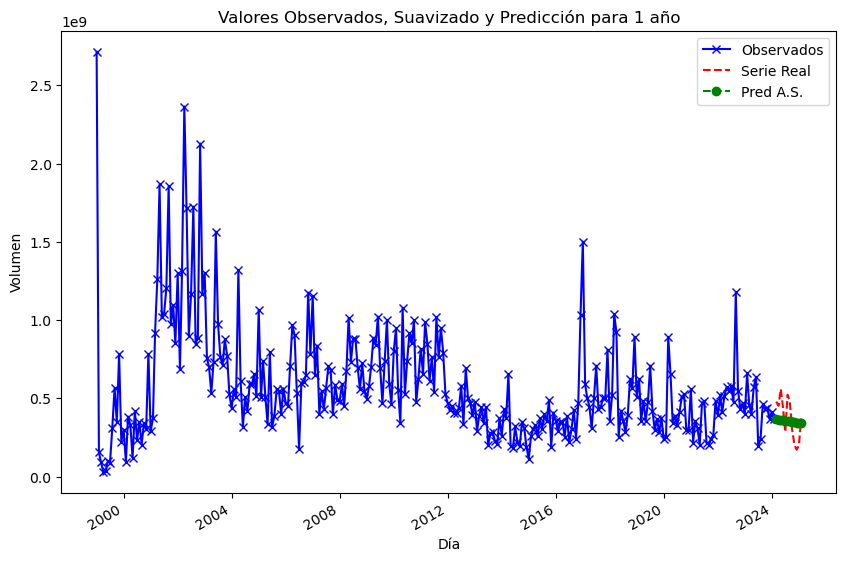

In [24]:
# Desdiferenciamos la serie para representar las predicciones
last_log_value = nvdTr_log.iloc[-1]
pred_log = last_log_value + predicciones_as.cumsum()
pred_final_as = np.exp(pred_log)

# Crear un gráfico con matplotlib
plt.figure(figsize=(10, 6))
# Valores observados
plt.plot(nvd_train.index, nvd_train["Volume"], label='Observados', marker='x', linestyle='-', color='blue')
# Valores reales
plt.plot(nvd_test.index, nvd_test['Volume'], label='Serie Real', linestyle='--', color='red')
# Predicción para 1 año
plt.plot(pred_final_as.index, pred_final_as, label='Pred A.S.', linestyle='--', marker='o', color='green')

plt.xlabel('Día')
plt.ylabel('Volumen')
plt.title('Valores Observados, Suavizado y Predicción para 1 año')
plt.legend()
plt.xticks(rotation=30, ha='right')
plt.show()

Vemos como la predicción con el método de suavizado Alisado simple, no es la más óptima.

# Modelo Alisado Doble

Para el método de suavizado Alisado Doble haremos dos modelos predictivos, uno con la tendencia adtivia y otro con la tendencia multiplicativa; eligiendo al que mejores resultados nos proporcione.

In [25]:
# Aplicar suavizado exponencial doble (Holt). ADITIVO
modelo_holt_add = sm.tsa.ExponentialSmoothing(nvdTr_logdiff, trend='add', damped_trend=False).fit()
# Obtener predicciones para 1 año
predicciones_h_add = modelo_holt_add.forecast(steps=12)
# Mostrar la descripción del modelo
modelo_holt_add.summary()
# para controlar los valores de alpha y beta: .fit(smooothing_level = alpha, smoothing_slope = beta,
#optimized = False)

Dep. Variable:,Volume,No. Observations:,301
Model:,ExponentialSmoothing,SSE,79.580
Optimized:,True,AIC,-392.436
Trend:,Additive,BIC,-377.607
Seasonal:,None,AICC,-392.150
Seasonal Periods:,None,Date:,"Wed, 19 Mar 2025"
Box-Cox:,False,Time:,18:34:31
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.4901e-08,alpha,True
smoothing_trend,1.4731e-08,beta,True


Vemos como también tiene un error SSE un poco menor. Vemos como 𝛼 tiene un valor de 1.4901e-08 lo que nos dice que el peso que le da a los datos del presente es ínfimo al igual que el modelo alisado simple, beta tiene un valor 1.4731e-08 indicándonos que no se ha detectado ninguna tendencia en los datos. Los valores de AIC, BIC y AICC son más altos que el modelo alisado simple; lo que nos indica que el modelo alisa simple parece más adecuado.

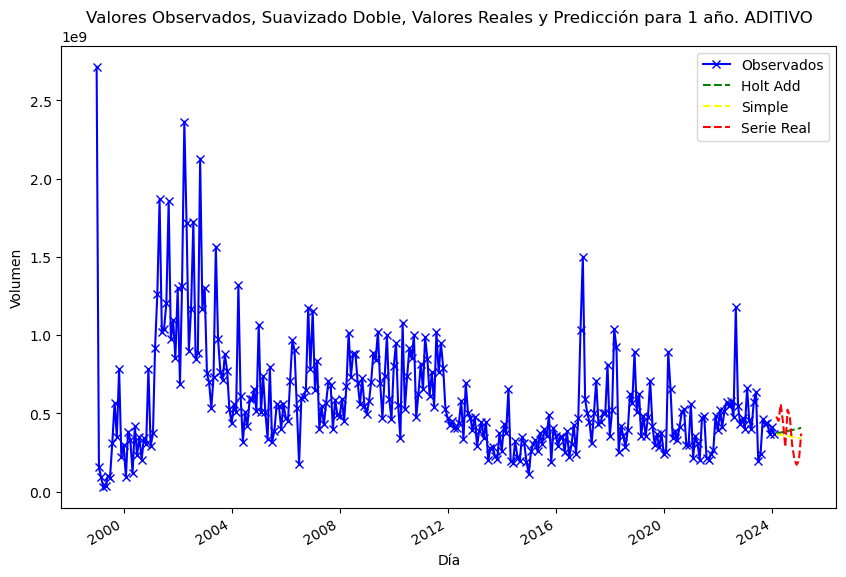

In [26]:
# Desdiferenciamos la serie para representar las predicciones
last_log_value = nvdTr_log.iloc[-1]
pred_log = last_log_value + predicciones_h_add.cumsum()
pred_final_ad_add = np.exp(pred_log)

# Representamos los distintos gráficos
plt.figure(figsize=(10, 6))
plt.plot(nvd_train.index, nvd_train['Volume'], label='Observados', marker='x', linestyle='-', color='blue')
plt.plot(pred_final_ad_add.index, pred_final_ad_add, label='Holt Add', linestyle='--',color='green')
plt.plot(pred_final_as.index, pred_final_as, label='Simple', linestyle='--', color='yellow')
plt.plot(nvd_test.index, nvd_test['Volume'], label='Serie Real', linestyle='--', color='red')

plt.xlabel('Día')
plt.ylabel('Volumen')
plt.title('Valores Observados, Suavizado Doble, Valores Reales y Predicción para 1 año. ADITIVO')
plt.legend()
plt.xticks(rotation=30, ha='right')
plt.show()

El modelo Alisado Doble con tendencia aditiva no precide adecuadamente.

In [27]:
# Aplicar suavizado exponencial doble (Holt). MULTIPLICATIVO
modelo_holt_mul = sm.tsa.ExponentialSmoothing(nvdTr_logdiff+3, trend='mul', damped_trend=False).fit()
# Obtener predicciones para 1 año
predicciones_h_mul = modelo_holt_mul.forecast(steps=12)
# Mostrar la descripción del modelo
modelo_holt_mul.summary()
# para controlar los valores de alpha y beta: .fit(smooothing_level = alpha, smoothing_slope = beta,
#optimized = False)

Dep. Variable:,Volume,No. Observations:,301
Model:,ExponentialSmoothing,SSE,79.580
Optimized:,True,AIC,-392.435
Trend:,Multiplicative,BIC,-377.607
Seasonal:,None,AICC,-392.150
Seasonal Periods:,None,Date:,"Wed, 19 Mar 2025"
Box-Cox:,False,Time:,18:34:31
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.4901e-08,alpha,True
smoothing_trend,1.4901e-08,beta,True


El método alisado doble con tendencia multiplicativa vemos como podemos sacar conclusiones muy parecidas al metodo de alisado doble con tendencia aditiva.

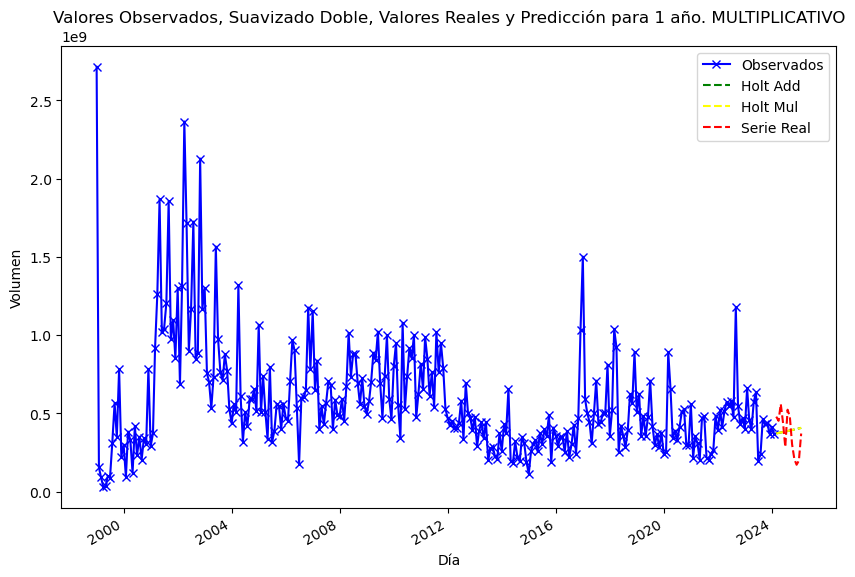

In [28]:
# Desdiferenciamos la serie para representar las predicciones
last_log_value = nvdTr_log.iloc[-1]
pred_log = last_log_value + (predicciones_h_mul-3).cumsum()
pred_final_ad_mul = np.exp(pred_log)

# Representamos los distintos gráficos
plt.figure(figsize=(10, 6))
plt.plot(nvd_train.index, nvd_train['Volume'], label='Observados', marker='x', linestyle='-', color='blue')
plt.plot(pred_final_ad_add.index, pred_final_ad_add, label='Holt Add', linestyle='--',color='green')
plt.plot(pred_final_ad_mul.index, pred_final_ad_mul, label='Holt Mul', linestyle='--', color='yellow')
plt.plot(nvd_test.index, nvd_test['Volume'], label='Serie Real', linestyle='--', color='red')

plt.xlabel('Día')
plt.ylabel('Volumen')
plt.title('Valores Observados, Suavizado Doble, Valores Reales y Predicción para 1 año. MULTIPLICATIVO')
plt.legend()
plt.xticks(rotation=30, ha='right')
plt.show()

El modelo Alisado Doble con tendencia multiplicativa no precide adecuadamente.

# Modelo Holt-Winters

Finalmente realizamos el último método de suavizado con el modelo Holt-Winters. Donde crearemos 4 modelos predictivos en base a la elección de los parámetros tendencia y estacionalidad. Seguidamente comprobaremos cual es el modelo que presenta un error menor MAE.

In [29]:
# Trend= Aditivo, Seasonal= Aditivo  -----  MODELO 1

modelo_holt_winters_aa = sm.tsa.ExponentialSmoothing(nvdTr_logdiff, trend='add', 
                                                  seasonal='additive', seasonal_periods=12).fit()
# Obtener predicciones para 1 año
predicciones_hw_aa = modelo_holt_winters_aa.forecast(steps=12)

# Desdiferenciamos la serie para representar las predicciones
last_log_value = nvdTr_log.iloc[-1]
pred_log = last_log_value + predicciones_hw_aa.cumsum()
pred_final_hw_aa = np.exp(pred_log)

# Calculamos el error MAE
errores_aa = abs(nvd_test['Volume']-pred_final_hw_aa)
mae_aa = np.mean(errores_aa)
print("Error MAE Modelo 1:",mae_aa)


# Trend= Multiplicativo, Seasonal= Aditivo  ----  MODELO 2

modelo_holt_winters_ma = sm.tsa.ExponentialSmoothing(nvdTr_logdiff+3, trend='mul', 
                                                  seasonal='additive', seasonal_periods=12).fit()
# Obtener predicciones para 1 año
predicciones_hw_ma = modelo_holt_winters_ma.forecast(steps=12)

# Desdiferenciamos la serie para representar las predicciones
last_log_value = nvdTr_log.iloc[-1]
pred_log = last_log_value + (predicciones_hw_ma-3).cumsum()
pred_final_hw_ma = np.exp(pred_log)

# Calculamos el error MAE
errores_ma = abs(nvd_test['Volume']-pred_final_hw_ma)
mae_ma = np.mean(errores_ma)
print("Error MAE Modelo 2:",mae_ma)


# Trend= Aditivo, Seasonal= Multiplicativo  ----  MODELO 3

modelo_holt_winters_am = sm.tsa.ExponentialSmoothing(nvdTr_logdiff+3, trend='add', 
                                                  seasonal='multiplicative', seasonal_periods=12).fit()
# Obtener predicciones para 1 año
predicciones_hw_am = modelo_holt_winters_am.forecast(steps=12)

# Desdiferenciamos la serie para representar las predicciones
last_log_value = nvdTr_log.iloc[-1]
pred_log = last_log_value + (predicciones_h_mul-3).cumsum()
pred_final_hw_am = np.exp(pred_log)

# Calculamos el error MAE
errores_am = abs(nvd_test['Volume']-pred_final_hw_am)
mae_am = np.mean(errores_am)
print("Error MAE Modelo 3:",mae_am)


# Trend= Multiplicativo, Seasonal= Multiplicativo  ----  MODELO 4

modelo_holt_winters_mm = sm.tsa.ExponentialSmoothing(nvdTr_logdiff+3, trend='mul', 
                                                  seasonal='multiplicative', seasonal_periods=12).fit()
# Obtener predicciones para 1 año
predicciones_hw_mm = modelo_holt_winters_mm.forecast(steps=12)

# Desdiferenciamos la serie para representar las predicciones
last_log_value = nvdTr_log.iloc[-1]
pred_log = last_log_value + (predicciones_hw_mm-3).cumsum()
pred_final_hw_mm = np.exp(pred_log)

# Calculamos el error MAE
errores_mm = abs(nvd_test['Volume']-pred_final_hw_mm)
mae_mm = np.mean(errores_mm)
print("Error MAE Modelo 4:",mae_mm)

Error MAE Modelo 1: 137328565.71908587
Error MAE Modelo 2: 137252700.22077796


C:\Users\adria\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Error MAE Modelo 3: 124815132.95205872
Error MAE Modelo 4: 128844180.1375406


C:\Users\adria\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Vemos como el modelo 3 con tendencia aditiva y estacionalidad multiplicativa tiene un menor error MAE, lo cual es el mejor modelo Holt-Winter.

In [30]:
# Mostrar la descripción del modelo ganardor (Modelo 1)
modelo_holt_winters_am.summary()

Dep. Variable:,Volume,No. Observations:,301
Model:,ExponentialSmoothing,SSE,74.648
Optimized:,True,AIC,-387.693
Trend:,Additive,BIC,-328.379
Seasonal:,Multiplicative,AICC,-385.267
Seasonal Periods:,12,Date:,"Wed, 19 Mar 2025"
Box-Cox:,False,Time:,18:34:32
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.4901e-08,alpha,True
smoothing_trend,8.4882e-09,beta,True


Vemos como tiene el error SSE más bajo de los métodos aplicado. Vemos como los valores de alpha, beta y gamma son muy ajos, indicándonos que el peso de que se le da al pasado es mucho mayo, y que el modelo no ha sido capaz de detectar tendencia ni estacionalidad. Vemos que las métricas AIC, BIC y AICC son mayores que las métricas del alisado simple, que nos indica que el mejor modelo es el alisado simple a pesar de tener el error SSE más bajo.

Visualizamos las predicciones del modelo ganador Holt-Winters y los parámetros

In [31]:
predicciones_hw_am

2024-03-01    3.204665
2024-04-01    3.009523
2024-05-01    2.815430
2024-06-01    3.174336
2024-07-01    2.857747
2024-08-01    3.095615
2024-09-01    3.123979
2024-10-01    2.995662
2024-11-01    2.993258
2024-12-01    3.032798
2025-01-01    2.982844
2025-02-01    2.788713
Freq: MS, dtype: float64

In [32]:
modelo_holt_winters_am.params

{'smoothing_level': 1.4901161202837442e-08,
 'smoothing_trend': 8.488152819364618e-09,
 'smoothing_seasonal': 8.394351755184236e-18,
 'damping_trend': nan,
 'initial_level': 3.023470830895147,
 'initial_trend': 7.837475439136085e-05,
 'initial_seasons': array([0.91493144, 1.05169615, 0.98762965, 0.92391069, 1.04166233,
        0.93774928, 1.01577774, 1.02505844, 0.98292924, 0.98211495,
        0.99506283, 0.97864799]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

Realizamos un modelo HoltWinters con la serie sin haberle aplicado ninguna transformacióno anteriormente para comparar predicciones.

C:\Users\adria\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


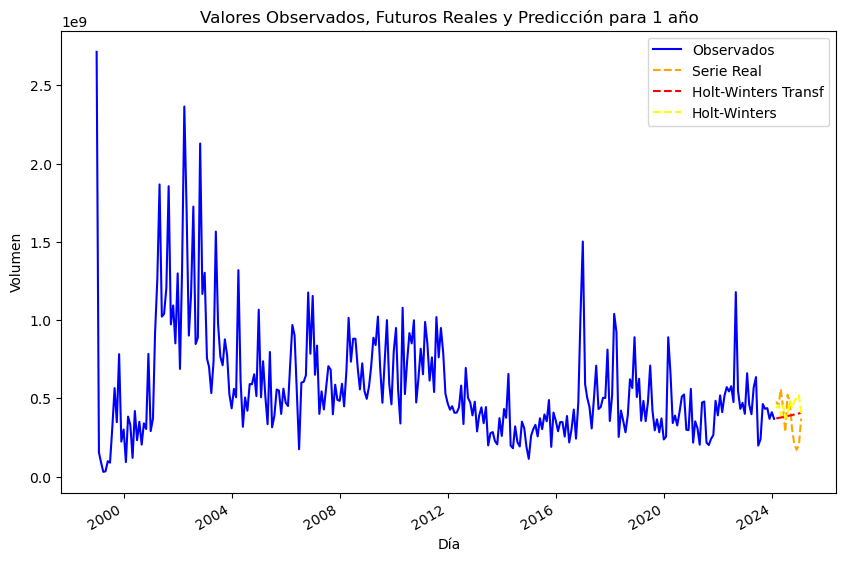

In [33]:
modelo_holt_winters_am = sm.tsa.ExponentialSmoothing(nvd_train["Volume"], trend='add', 
                                                  seasonal='multiplicative', seasonal_periods=12).fit()
# Obtener predicciones para 1 año
predicciones_hw_am = modelo_holt_winters_am.forecast(steps=12)


# Gráficas
plt.figure(figsize=(10, 6))
plt.plot(nvd_train.index, nvd_train['Volume'], label='Observados', linestyle='-', color='blue')
plt.plot(nvd_test.index, nvd_test['Volume'], label='Serie Real', linestyle='--', color='orange')
plt.plot(pred_final_hw_am.index, pred_final_hw_am, label='Holt-Winters Transf', linestyle='--',color='red')
plt.plot(predicciones_hw_am.index, predicciones_hw_am, label='Holt-Winters', linestyle='--',color='yellow')

plt.xlabel('Día')
plt.ylabel('Volumen')
plt.title('Valores Observados, Futuros Reales y Predicción para 1 año')
plt.legend()
plt.xticks(rotation=30, ha='right')
plt.show()

Podemos ver como ambos modelos Holt Winters no predicen adecuadamente a los valores futuros. Seguidamente analizamos los errores MAE del modelo 3 HoltWinters

In [34]:
print(errores_am.head())

Date
2024-03-01    1.071501e+08
2024-04-01    7.755981e+07
2024-05-01    1.820271e+08
2024-06-01    5.754197e+07
2024-07-01    9.903915e+07
Freq: MS, dtype: float64


(array([19783., 19844., 19905., 19967., 20028., 20089.]),
 [Text(19783.0, 0, '2024-03'),
  Text(19844.0, 0, '2024-05'),
  Text(19905.0, 0, '2024-07'),
  Text(19967.0, 0, '2024-09'),
  Text(20028.0, 0, '2024-11'),
  Text(20089.0, 0, '2025-01')])

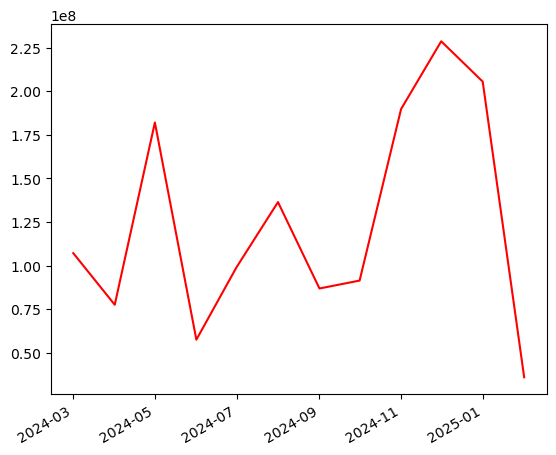

In [35]:
# esto nos permite conocer en qué meses se cometieron más errores
plt.plot(errores_am, label='errores', linestyle='-', color='red')
plt.xticks(rotation=30, ha='right')

Vemos como el modelo tiene mayor dificultad para predecir los últimos datos, aunque el valor final de los datos futuro lo ha conseguido acertar. 

### Conclusión

EL mejor método de suavizado es el métododo de alisado simple, donde se obtienen las métrica AIC, BIC, y AICC más bajas.  

# Logaritmo - Diferenciar - Desdiferenciar Serie


nvd_log = np.log(nvd_train['Volume'])

nvd_log_diff = nvd_log.diff().dropna()

modelo_hw_diff = sm.tsa.ExponentialSmoothing(nvd_log,
                                      trend='add',
                                      seasonal='multiplicative',
                                      seasonal_periods=12).fit()

pred_diff = modelo_hw_diff.forecast(steps=12)

errores_am = abs(nvd_test['Volume']-pred_diff)
mae_am = np.mean(errores_am)
print("Error MAE Modelo 3:",mae_am) #Vemos como ha empeorado bastante del modelo 3 antenior

last_log_value = vuelos_log.iloc[-1]  

pred_log = last_log_value + pred_diff.cumsum()

pred_final = np.exp(pred_log)

print(pred_final)

plt.figure(figsize=(10, 6))
plt.plot(vuelos_TR.index, vuelos_TR['Vuelos'], label='Observados', linestyle='-', color='blue')
plt.plot(vuelos_rest.index, vuelos_rest['Vuelos'], label='Serie Real', linestyle='--', color='orange')
plt.plot(pred_final.index, pred_final, label='Holt-Winters_trans', linestyle='--',color='red')
plt.plot(predicciones_hw.index, predicciones_hw, label='Holt-Winters', linestyle='--',color='green')
predicciones_hw
plt.xlabel('Día')
plt.ylabel('PRECIO')
plt.title('Valores Observados, Futuros Reales y Predicción para 1 año')
plt.legend()
plt.xticks(rotation=30, ha='right')
plt.show()

# MODELOS ARIMA

Empezaremos ahoram a realizar modelos predictivos con los modelos ARIMA. El modelo se compone de tres componentes: AR (AutoRegresivo), que modela la relación entre el valor actual y los valores pasados; I (Integrado), que representa el número de diferenciaciones necesarias para hacer la serie estacionaria eliminando tendencias; y MA (Media Móvil), que captura la dependencia entre el valor actual y los errores pasados.

Realizamos una obserción de los datos originales

Text(0.5, 1.0, 'Serie original')

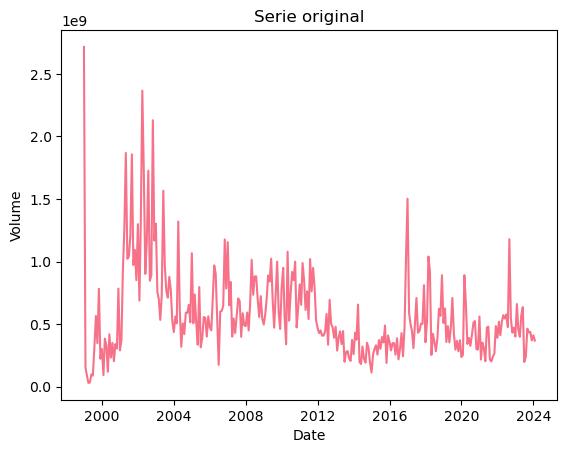

In [36]:
sns.lineplot(nvd_train["Volume"])
plt.title("Serie original")

Vemos como se comportan los datos si aplicamos el logaritmo a la serie con la idea de suavizar la heterocedasticidad que presenta la varianza.

Text(0.5, 1.0, 'Serie Transf.Logaritmo')

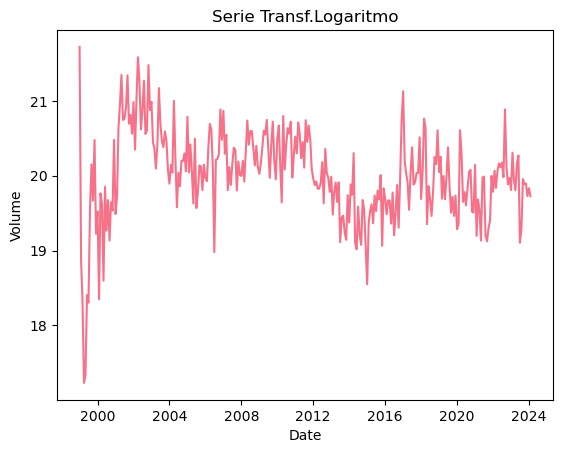

In [37]:
sns.lineplot(nvdTr_log)
plt.title("Serie Transf.Logaritmo")

Vemos como la varianza ha mejorado pero vemos que la serie presenta tendencias, para solucionar esto aplicaremos una diferenciación con la idea de buscar que la serie sea estacionaria en media.

Text(0.5, 1.0, 'Serie diferenciada de orden 1')

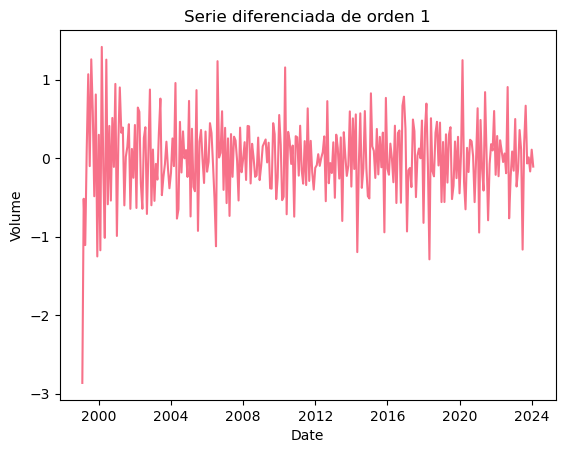

In [38]:
sns.lineplot(nvdTr_logdiff)
plt.title("Serie diferenciada de orden 1")

Aplicamos los tests Dickey-Fuller (ADF) y Kwiatkowski-Phillips-Schmidt-Shin (KPSS) para comprobar si la serie es estacionaria en media. Donde buscamos que el test ADF rechaze H0, y no se rechaze H0 en el test KPSS.

In [39]:
print('Test estacionariedad serie original')
print(f'ADF Statistic: {adfuller(nvd_train["Volume"])[0]}, p-value: {adfuller(nvd_train["Volume"])[1]}')
print(f'KPSS Statistic: {kpss(nvd_train["Volume"])[0]}, p-value: {kpss(nvd_train["Volume"])[1]}')

print('\nTest estacionariedad serie transformacion logarítmica')
print(f'ADF Statistic: {adfuller(nvdTr_log)[0]}, p-value: {adfuller(nvdTr_log)[1]}')
print(f'KPSS Statistic: {kpss(nvdTr_log)[0]}, p-value: {kpss(nvdTr_log)[1]}')

print('\nTest estacionariedad serie Transformada + diferenciada de orden 1')
print(f'ADF Statistic: {adfuller(nvdTr_logdiff)[0]}, p-value: {adfuller(nvdTr_logdiff)[1]}')
print(f'KPSS Statistic: {kpss(nvdTr_logdiff)[0]}, p-value: {kpss(nvdTr_logdiff)[1]}')

# Sería bueno diferenciar, ya que aunque solo haya pasado el test ADF satisfactoriamente indicandonos 
# que es estacionario en media; si diferenciamos las dos métricas nos indicarán esa estacionariedad en media.
# Además se pueden ver unas ligeras tendencias que fluctuan cuando no diferenciamos 
# y solo aplicamos la transformación logarítmiica

Test estacionariedad serie original
ADF Statistic: -2.7955456318578924, p-value: 0.058912865308506215
KPSS Statistic: 0.8816924983056771, p-value: 0.01

Test estacionariedad serie transformacion logarítmica
ADF Statistic: -4.137974934180469, p-value: 0.0008376282534065183
KPSS Statistic: 0.4637371640312652, p-value: 0.04983397206503037

Test estacionariedad serie Transformada + diferenciada de orden 1
ADF Statistic: -10.878052293239486, p-value: 1.3162055560137885e-19
KPSS Statistic: 0.05497286743930467, p-value: 0.1


C:\Users\adria\AppData\Local\Temp\ipykernel_6132\3397821513.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  print(f'KPSS Statistic: {kpss(nvd_train["Volume"])[0]}, p-value: {kpss(nvd_train["Volume"])[1]}')
C:\Users\adria\AppData\Local\Temp\ipykernel_6132\3397821513.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  print(f'KPSS Statistic: {kpss(nvd_train["Volume"])[0]}, p-value: {kpss(nvd_train["Volume"])[1]}')
C:\Users\adria\AppData\Local\Temp\ipykernel_6132\3397821513.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  print(f'KPSS Statistic: {kpss(nvdTr_logdiff)[0]}, p-value: {kpss(nvdTr_logdiff)[1]}')
C:\Users\adr

Vemos como la serie original no satisface ambas pruebas, la serie con el logaritmo setisface solo el test ADF, y la serie con el logaritmo y diferenciada si satisface ambos tests; lo que hace que la serie sea estacionaria en media. Esto se puede ver de forma visual con los siguientes gráficos. Al diferenciar una vez la serie I = 1 en nuestro modelo ARIMA.


<Axes: title={'center': 'Transf.Log + Diferenciación orden 1'}, xlabel='Date'>

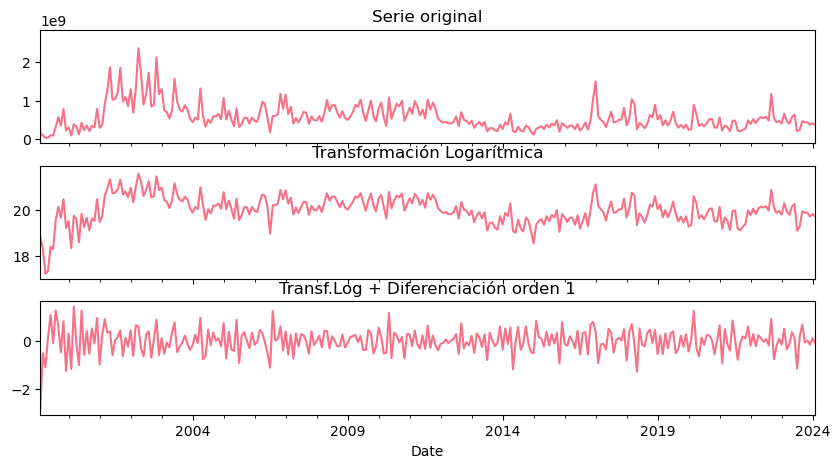

In [40]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 5), sharex=True)
nvd_train["Volume"].plot(ax=axs[0], title='Serie original')
nvdTr_log.plot(ax=axs[1], title='Transformación Logarítmica')
nvdTr_logdiff.plot(ax=axs[2], title='Transf.Log + Diferenciación orden 1')

Seguidamente para elegir los valores de AR y MA, nos fijaremos en los lags que superen el nivel de significación (0.05) de la s funciones de autocorrelación parcial y autocorrelación, respectivamente.

Text(0.5, 1.0, 'Autoorrelación parcial serie diferenciada (order=1)')

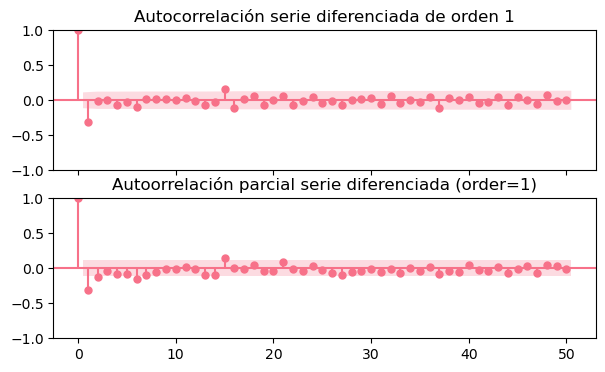

In [41]:
# Grafico de autocorrelación para la serie original y la serie diferenciada
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 4), sharex=True)
plot_acf(nvdTr_logdiff, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación serie diferenciada de orden 1')
plot_pacf(nvdTr_logdiff, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autoorrelación parcial serie diferenciada (order=1)')

Observamos que los posibles modelos ARIMA candidatos son:
- Modelo 1: ARIMA (2, 1, 1)
- Modelo 2: ARIMA (6, 1, 1)

Descomponemos la serie y analizamos cada componente, tanto para un modelo aditivo como para un modelo multiplicativo.

In [42]:
# Descomposición de la serie original y la serie diferenciada
# ==============================================================================
res_decompose_add = seasonal_decompose(nvdTr_logdiff, model='additive', extrapolate_trend='freq')
res_decompose_mul = seasonal_decompose(nvdTr_logdiff+3, model='multiplicative', extrapolate_trend='freq')

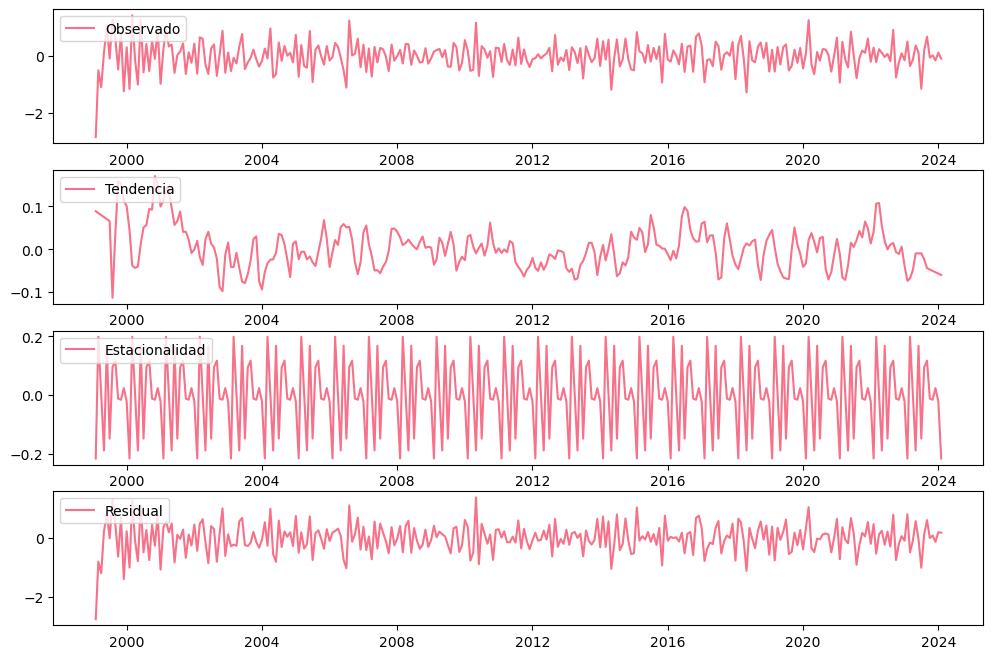

In [43]:
# Visualizar las componentes  -----  ADITIVO
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(res_decompose_add.observed, label='Observado')
plt.legend(loc='upper left')

plt.subplot(4, 1, 2)
plt.plot(res_decompose_add.trend, label='Tendencia')
plt.legend(loc='upper left')

plt.subplot(4, 1, 3)
plt.plot(res_decompose_add.seasonal, label='Estacionalidad')
plt.legend(loc='upper left')

plt.subplot(4, 1, 4)
plt.plot(res_decompose_add.resid, label='Residual')
plt.legend(loc='upper left')

plt.show()

Vemos como en el modelo Aditivo los residuos tienen un distribución uniforme, la estacionalidad presenta un patrón clara, y no se presenta una tendencia clara en la serie.

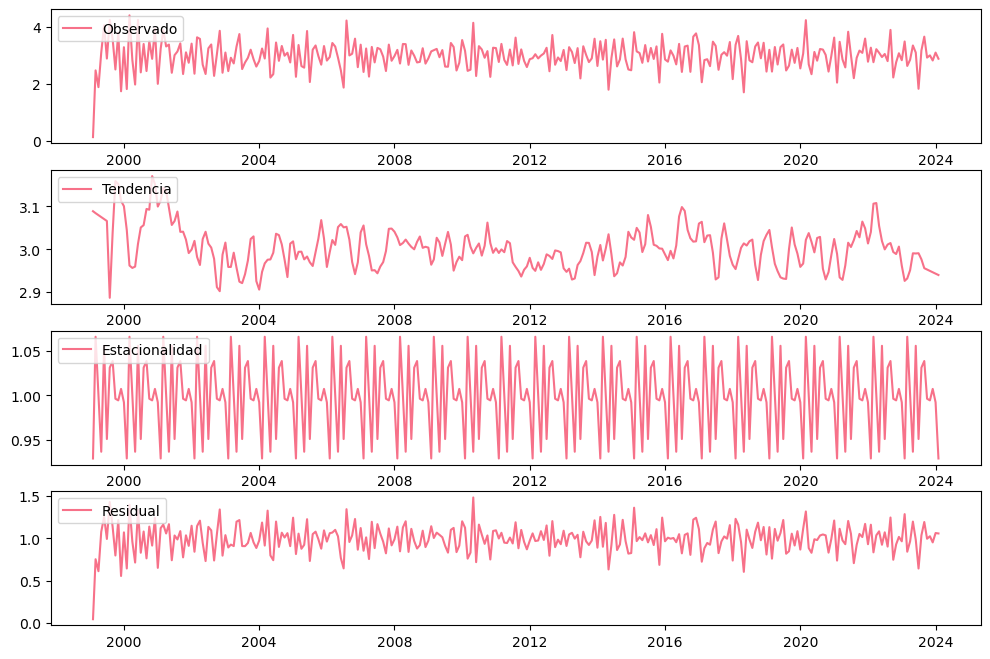

In [44]:
# Visualizar las componentes  -----  MULTILICATIVO
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(res_decompose_mul.observed, label='Observado')
plt.legend(loc='upper left')

plt.subplot(4, 1, 2)
plt.plot(res_decompose_mul.trend, label='Tendencia')
plt.legend(loc='upper left')

plt.subplot(4, 1, 3)
plt.plot(res_decompose_mul.seasonal, label='Estacionalidad')
plt.legend(loc='upper left')

plt.subplot(4, 1, 4)
plt.plot(res_decompose_mul.resid, label='Residual')
plt.legend(loc='upper left')

plt.show()

Se puede apreciar como se pueden sacar las mismas afirmaciones para el modelo multiplicativo como para el modelo aditivo. Posteriormente analizaremos la estacionalidad. En nuestro caso haremos una diferenciación de orden 12 porque nuestros datos se distribuyen de tal forma que hay una observación por mes, y nuestro objetivo es predecir a razon de un año, ya que se observa un patrón definido que se repite cada año en los datos.

In [45]:
# Diferenciaciación de orden 1 combinada con diferenciación estacional
# ==============================================================================
nvd_train_diff1_12 = nvdTr_logdiff.diff(12).dropna()
print('\nTest estacionariedad serie diferenciada de orden 12')
print(f'ADF Statistic: {adfuller(nvd_train_diff1_12)[0]}, p-value: {adfuller(nvd_train_diff1_12)[1]}')
print(f'KPSS Statistic: {kpss(nvd_train_diff1_12)[0]}, p-value: {kpss(nvd_train_diff1_12)[1]}')


Test estacionariedad serie diferenciada de orden 12
ADF Statistic: -7.515037956286016, p-value: 3.923608431635586e-11
KPSS Statistic: 0.19012408597068978, p-value: 0.1


C:\Users\adria\AppData\Local\Temp\ipykernel_6132\2674158274.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  print(f'KPSS Statistic: {kpss(nvd_train_diff1_12)[0]}, p-value: {kpss(nvd_train_diff1_12)[1]}')
C:\Users\adria\AppData\Local\Temp\ipykernel_6132\2674158274.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  print(f'KPSS Statistic: {kpss(nvd_train_diff1_12)[0]}, p-value: {kpss(nvd_train_diff1_12)[1]}')


El realizar la diferenciación de orden 12 vemos como pasa satisfactoriamente los tests ADF y KPSS, lo que nos indica que la serie es estacionaria en media. Seguidamente seguimos los mismos pasos anteriores para determinar AR y MA en cuanto a la estacionalidad.

Text(0.5, 1.0, 'Autoorrelación parcial serie diferenciada (order=1)')

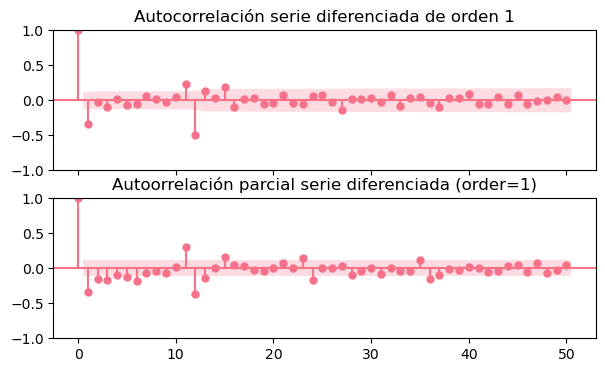

In [46]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 4), sharex=True)
plot_acf(nvd_train_diff1_12, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación serie diferenciada de orden 1')
plot_pacf(nvd_train_diff1_12, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autoorrelación parcial serie diferenciada (order=1)')

Elemgimos como posbiles modelos ARIMA:
- Modelo 1:  ARIMA (2, 1, 1)(6, 1, 1)[12]
- Modelo 2: ARIMA (6, 1, 1)(6, 1, 1)[12]

Comprobamos estos modelos con los datos futuros, para ver si predicen bien.

In [47]:
# Modelo SARIMAX con statsmodels.Sarimax
# ==============================================================================
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
modelo1 = SARIMAX(endog = nvd_train["Volume"], order = (2, 1, 1), seasonal_order = (6, 1, 1, 12))
modelo2 = SARIMAX(endog = nvd_train["Volume"], order = (6, 1, 1), seasonal_order = (6, 1, 1, 12))

modelo_res1 = modelo1.fit(disp=0)
modelo_res2 = modelo2.fit(disp=0)
warnings.filterwarnings("default")

C:\Users\adria\anaconda3\Lib\site-packages\jupyter_client\session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [48]:
print(modelo_res1.summary())
print(modelo_res2.summary())

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  302
Model:             SARIMAX(2, 1, 1)x(6, 1, 1, 12)   Log Likelihood               -6061.903
Date:                            Wed, 19 Mar 2025   AIC                          12145.807
Time:                                    18:35:58   BIC                          12186.137
Sample:                                01-01-1999   HQIC                         12161.967
                                     - 02-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1857      0.142      1.311      0.190      -0.092       0.463
ar.L2         -0.0813      0.115   

C:\Users\adria\anaconda3\Lib\site-packages\jupyter_client\session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Observando los dos modelos y los criterios AIC y BIC vemos como el segundo tiene métricas ligeramente inferiores lo cuál es ideal, vemos que en ambos modelos el Test de Ljung-Box nos indica que los residuos no muestran autocorrelación, lo cual es ideal; pero el test de Jarque-Bera nos indica que los residuos no estan normalizados en ambos modelos. Además la elección de parámetros en ambos modelos no parece haber sido la más acertada.

In [49]:
from statsmodels.stats.diagnostic import acorr_ljungbox
estadistico_lb_1, p_valor_lb_1 = acorr_ljungbox(modelo_res1.resid, lags=[12]).iloc[0]
estadistico_lb_2, p_valor_lb_2 = acorr_ljungbox(modelo_res2.resid, lags=[12]).iloc[0]

print(f"El Test Ljung-Box para el modelo 1: Estadístico:{estadistico_lb_1}  p-valor:{p_valor_lb_1}\t")
print(f"El Test Ljung-Box para el modelo 2: Estadístico:{estadistico_lb_2}  p-valor:{p_valor_lb_2}")

# Ninguno de los dos modelos rechaza H0 por lo que existe autocorrelación significativa en los residuos

El Test Ljung-Box para el modelo 1: Estadístico:19.354299837357818  p-valor:0.08032938946746719	
El Test Ljung-Box para el modelo 2: Estadístico:17.880431498636018  p-valor:0.11936955797941054


In [50]:
# Predicción
# ==============================================================================
predicciones_statsmodels1 = modelo_res1.get_forecast(steps=12).predicted_mean
predicciones_statsmodels1.name = 'predicciones_statsmodels'
display(predicciones_statsmodels1.head(4))

predicciones_statsmodels2 = modelo_res2.get_forecast(steps=12).predicted_mean
predicciones_statsmodels2.name = 'predicciones_statsmodels'
display(predicciones_statsmodels2.head(4))

2024-03-01    5.090417e+08
2024-04-01    4.760315e+08
2024-05-01    3.070347e+08
2024-06-01    4.075595e+08
Freq: MS, Name: predicciones_statsmodels, dtype: float64

2024-03-01    4.966420e+08
2024-04-01    4.460870e+08
2024-05-01    3.112915e+08
2024-06-01    4.101000e+08
Freq: MS, Name: predicciones_statsmodels, dtype: float64

In [51]:
predicciones_statsmodels1

2024-03-01    5.090417e+08
2024-04-01    4.760315e+08
2024-05-01    3.070347e+08
2024-06-01    4.075595e+08
2024-07-01    3.627860e+08
2024-08-01    2.950371e+08
2024-09-01    4.075831e+08
2024-10-01    3.976919e+08
2024-11-01    3.300823e+08
2024-12-01    4.539322e+08
2025-01-01    4.124388e+08
2025-02-01    3.636843e+08
Freq: MS, Name: predicciones_statsmodels, dtype: float64

Representamos ambos modelos en gráficos distintos.

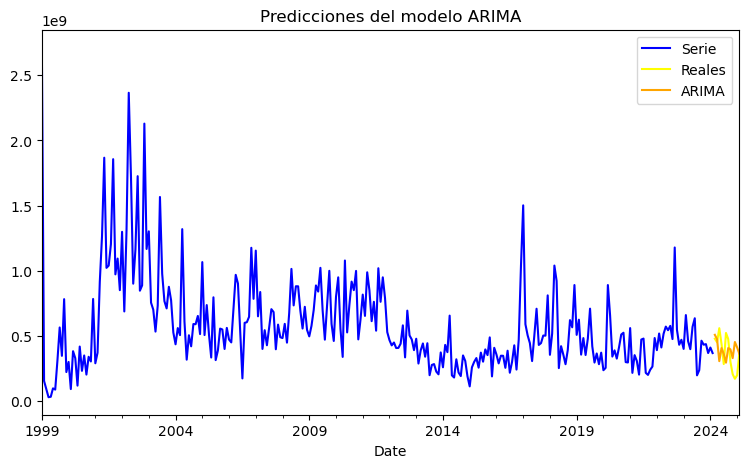

C:\Users\adria\anaconda3\Lib\site-packages\jupyter_client\session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [52]:
# Plot predictions - MODELO 1
fig, ax = plt.subplots(figsize=(9, 5))
nvd_train["Volume"].plot(ax=ax, label='Serie', color="blue")
nvd_test["Volume"].plot(ax=ax, label='Reales', color="yellow")
predicciones_statsmodels1.plot(ax=ax, label='ARIMA', color="orange")
ax.set_title('Predicciones del modelo ARIMA')
ax.legend();

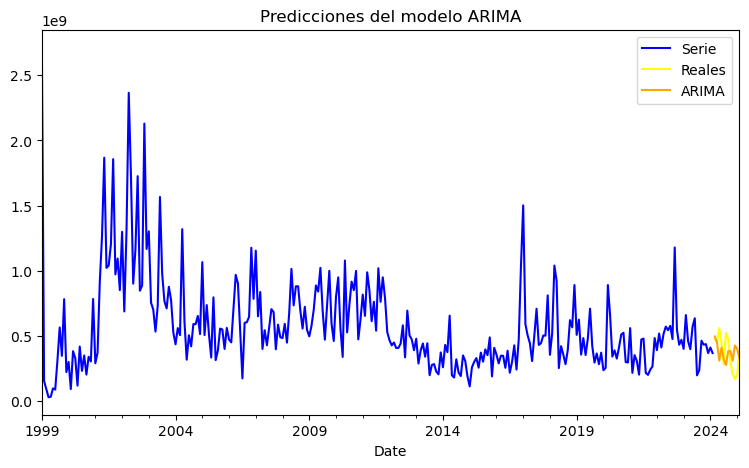

C:\Users\adria\anaconda3\Lib\site-packages\jupyter_client\session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [53]:
# Plot predictions - MODELO 2
fig, ax = plt.subplots(figsize=(9, 5))
nvd_train["Volume"].plot(ax=ax, label='Serie', color="blue")
nvd_test["Volume"].plot(ax=ax, label='Reales', color="yellow")
predicciones_statsmodels2.plot(ax=ax, label='ARIMA', color="orange")
ax.set_title('Predicciones del modelo ARIMA')
ax.legend();

Vemos como en ambos modelos ARIMA las prediciones son poco fiables.

In [54]:
# Mean Squared Error (MSE)
mse = mean_squared_error(nvd_test["Volume"], predicciones_statsmodels1)
print(f'Mean Squared Error (MSE): {mse}')
# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')
# Mean Absolute Error (MAE)
mae = mean_absolute_error(nvd_test["Volume"], predicciones_statsmodels1)
print(f'Mean Absolute Error (MAE): {mae}')
print()

# Mean Squared Error (MSE)
mse = mean_squared_error(nvd_test["Volume"], predicciones_statsmodels2)
print(f'Mean Squared Error (MSE): {mse}')
# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')
# Mean Absolute Error (MAE)
mae = mean_absolute_error(nvd_test["Volume"], predicciones_statsmodels2)
print(f'Mean Absolute Error (MAE): {mae}')

Mean Squared Error (MSE): 2.3272249852262244e+16
Root Mean Squared Error (RMSE): 152552449.5124947
Mean Absolute Error (MAE): 119633340.28769422

Mean Squared Error (MSE): 2.167567762298271e+16
Root Mean Squared Error (RMSE): 147226619.95367113
Mean Absolute Error (MAE): 113452860.266005


C:\Users\adria\anaconda3\Lib\site-packages\jupyter_client\session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Observando los errores de ambos modelos, podemos ver como el modelo 2 presenta unos errores más bajos, y por ello es el más adecuado de los dos

In [55]:
nvd_test["Volume"] - predicciones_statsmodels1

Date
2024-03-01   -2.990671e+07
2024-04-01   -2.359051e+07
2024-05-01    2.528283e+08
2024-06-01    3.083253e+07
2024-07-01   -7.790054e+07
2024-08-01    2.284252e+08
2024-09-01    6.957196e+07
2024-10-01   -9.559744e+07
2024-11-01   -1.229545e+08
2024-12-01   -2.822494e+08
2025-01-01   -2.141916e+08
2025-02-01    7.551409e+06
Freq: MS, dtype: float64

Creamos un modelo ARIMA automático donde elegimos el rango máximo de AR y MA, dandole la libertad al algoritmo de que diferencie la serie si lo necesita.

In [56]:
# Auto arima: seleccion basada en AIC
# ==============================================================================
modelo_auto = auto_arima(
            y                 = nvd_train["Volume"],
            start_p           = 0,
            start_q           = 0,
            max_p             = 6,
            max_q             = 6,
            seasonal          = True,
            test              = 'adf',
            m                 = 12, # periodicidad de la estacionalidad
            d                 = None, # El algoritmo determina 'd'
            D                 = None, # El algoritmo determina 'D'
            trace             = True,
            error_action      = 'ignore',
            suppress_warnings = True,
            stepwise          = True
        )

C:\Users\adria\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\adria\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\adria\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\adria\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\adria\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\a

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=12749.840, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=12761.434, Time=0.03 sec


C:\Users\adria\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\adria\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=12664.311, Time=0.52 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=12691.324, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=13145.695, Time=0.02 sec


C:\Users\adria\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\adria\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\adria\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=12662.315, Time=0.05 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=12664.193, Time=0.15 sec


C:\Users\adria\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\adria\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=12665.628, Time=0.44 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=12663.617, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=12662.118, Time=0.08 sec


C:\Users\adria\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\adria\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\adria\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=12663.441, Time=0.38 sec


C:\Users\adria\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=12664.063, Time=0.23 sec


C:\Users\adria\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.36 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=12692.879, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=12664.529, Time=0.15 sec


C:\Users\adria\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\adria\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\adria\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=12661.591, Time=0.10 sec


C:\Users\adria\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=12662.666, Time=0.63 sec


C:\Users\adria\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=12663.438, Time=0.26 sec


C:\Users\adria\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.77 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : AIC=12679.032, Time=0.11 sec


C:\Users\adria\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\adria\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=12657.101, Time=0.22 sec


C:\Users\adria\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=12657.619, Time=1.44 sec


C:\Users\adria\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=12658.276, Time=0.65 sec


C:\Users\adria\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.87 sec


C:\Users\adria\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(0,0,0)[12] intercept   : AIC=12658.550, Time=0.35 sec


C:\Users\adria\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(0,0,0)[12] intercept   : AIC=12656.843, Time=0.61 sec


C:\Users\adria\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(1,0,0)[12] intercept   : AIC=12657.420, Time=1.97 sec


C:\Users\adria\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(0,0,1)[12] intercept   : AIC=12657.884, Time=1.25 sec


C:\Users\adria\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(1,0,1)[12] intercept   : AIC=inf, Time=2.00 sec
 ARIMA(1,0,3)(0,0,0)[12] intercept   : AIC=12661.600, Time=0.13 sec


C:\Users\adria\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\adria\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,3)(0,0,0)[12] intercept   : AIC=inf, Time=0.91 sec


C:\Users\adria\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,4)(0,0,0)[12] intercept   : AIC=12656.403, Time=0.83 sec


C:\Users\adria\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,4)(1,0,0)[12] intercept   : AIC=12656.843, Time=2.39 sec


C:\Users\adria\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,4)(0,0,1)[12] intercept   : AIC=12657.273, Time=1.79 sec


C:\Users\adria\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,4)(1,0,1)[12] intercept   : AIC=inf, Time=2.27 sec
 ARIMA(1,0,4)(0,0,0)[12] intercept   : AIC=12660.695, Time=0.16 sec


C:\Users\adria\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\adria\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,4)(0,0,0)[12] intercept   : AIC=inf, Time=1.12 sec


C:\Users\adria\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,5)(0,0,0)[12] intercept   : AIC=12657.426, Time=0.51 sec


C:\Users\adria\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,5)(0,0,0)[12] intercept   : AIC=12661.794, Time=0.20 sec


C:\Users\adria\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,5)(0,0,0)[12] intercept   : AIC=inf, Time=1.26 sec


C:\Users\adria\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,4)(0,0,0)[12]             : AIC=12661.200, Time=0.38 sec

Best model:  ARIMA(2,0,4)(0,0,0)[12] intercept
Total fit time: 29.321 seconds


C:\Users\adria\anaconda3\Lib\site-packages\jupyter_client\session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Vemos que el mejor modelo es ARIMA(2,0,4)(0,0,0)[12] con un valor AIC = 12661.200

In [57]:
# Modelo SARIMAX con statsmodels.Sarimax
# ==============================================================================
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
modelo_final = SARIMAX(endog = nvd_train["Volume"], order = (2,0,4), seasonal_order = (0,0,0,12))
modelo_final_res = modelo_final.fit(disp=0)
warnings.filterwarnings("default")
modelo_final_res.summary()

C:\Users\adria\anaconda3\Lib\site-packages\jupyter_client\session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Volume   No. Observations:                  302
Model:               SARIMAX(2, 0, 4)   Log Likelihood               -6323.600
Date:                Wed, 19 Mar 2025   AIC                          12661.200
Time:                        18:36:29   BIC                          12687.173
Sample:                    01-01-1999   HQIC                         12671.593
                         - 02-01-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8482      0.788      1.077      0.281      -0.695       2.392
ar.L2          0.1451      0.783      0.185      0.853      -1.390       1.680
ma.L1         -0.4512      0.794     -0.569      0.570      -2.007       1.104
ma.L2         -0.2853      0.472     -0.604      0.546      -1.211       0.640
ma.L3         -0.0402      0.152     -0.264      0.792      -0.338       0.258
ma.L4          0.0506      0.034      1.500      0.134      -0.016       0.117
sigma2      6.726e+16   1.95e-17   3.45e+33      0.000    6.73e+16    6.73e+16
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):               846.40
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               0.23   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.64e+49. Standard errors may be unstable.
"""

Vemos como en los modelos ARIMA anteriores no parece ser un buen modelo predictor, pero si el mejor de los hemos creado. Realizamos una predicción conjunta con todos los modelos.

In [58]:
predicciones_statsmodels_fin = modelo_final_res.get_forecast(steps=12).predicted_mean

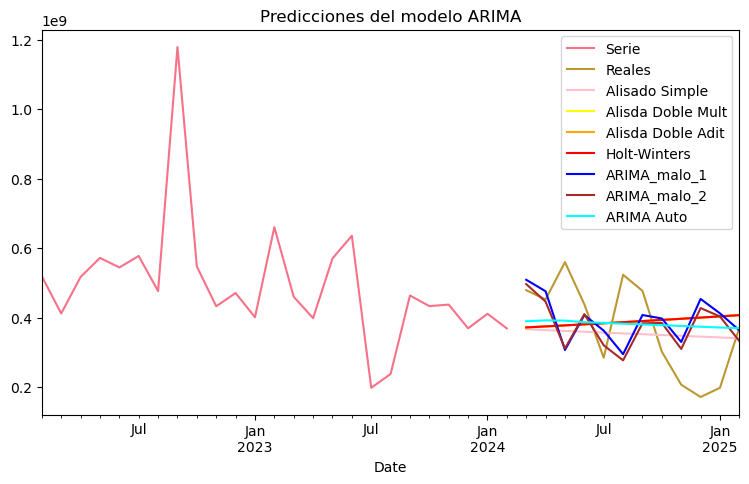

C:\Users\adria\anaconda3\Lib\site-packages\jupyter_client\session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [59]:
# Plot predictions
fig, ax = plt.subplots(figsize=(9, 5))
nvd_train["Volume"].tail(25).plot(ax=ax, label='Serie')
nvd_test["Volume"].plot(ax=ax, label='Reales')

pred_final_as.plot(ax=ax, label='Alisado Simple', color="pink")
pred_final_ad_mul.plot(ax=ax, label='Alisda Doble Mult', color="Yellow")
pred_final_ad_add.plot(ax=ax, label='Alisda Doble Adit', color="orange")
pred_final_hw_am.plot(ax=ax, label='Holt-Winters', color="red")
predicciones_statsmodels1.plot(ax=ax, label='ARIMA_malo_1', color="blue")
predicciones_statsmodels2.plot(ax=ax, label='ARIMA_malo_2', color="brown")
predicciones_statsmodels_fin.plot(ax=ax, label='ARIMA Auto', color="cyan")
ax.set_title('Predicciones del modelo ARIMA')
ax.legend();

Observamos como ningún modelo predice bien los datos futuros. Para asegurarnos que modelo de los tenemos es el mejor nos fijaremos en los errores MSE, RMSE y MAE de todos los modelos.

In [60]:
rmse = np.sqrt(mean_squared_error(nvd_test["Volume"], predicciones_statsmodels_fin))
mae = mean_absolute_error(nvd_test["Volume"], predicciones_statsmodels_fin)
print("Mean Absolute Error:", mae)
print("Root Mean Square Error:", rmse)

Mean Absolute Error: 110793817.44927865
Root Mean Square Error: 124885651.40630862


C:\Users\adria\anaconda3\Lib\site-packages\jupyter_client\session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [61]:
# Mean Squared Error (MSE)
mse = mean_squared_error(nvd_test["Volume"], predicciones_statsmodels_fin)
print(f'Mean Squared Error (MSE): {mse}')

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Mean Absolute Error (MAE)
mae = mean_absolute_error(nvd_test["Volume"], predicciones_statsmodels_fin)
print(f'Mean Absolute Error (MAE): {mae}')

Mean Squared Error (MSE): 1.5596425927178034e+16
Root Mean Squared Error (RMSE): 124885651.40630862
Mean Absolute Error (MAE): 110793817.44927865


C:\Users\adria\anaconda3\Lib\site-packages\jupyter_client\session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# Comparación Final de Modelos


In [62]:

print("Modelo Alisado Simple")
# Mean Squared Error (MSE)
mse = mean_squared_error(nvd_test["Volume"], pred_final_as)
print(f'Mean Squared Error (MSE): {mse}')
# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')
# Mean Absolute Error (MAE)
mae = mean_absolute_error(nvd_test["Volume"], pred_final_as)
print(f'Mean Absolute Error (MAE): {mae}')
print()

print("Modelo Alisado Doble Multiplicativo")
# Mean Squared Error (MSE)
mse = mean_squared_error(nvd_test["Volume"], pred_final_ad_mul)
print(f'Mean Squared Error (MSE): {mse}')
# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')
# Mean Absolute Error (MAE)
mae = mean_absolute_error(nvd_test["Volume"], pred_final_ad_mul)
print(f'Mean Absolute Error (MAE): {mae}')
print()

print("Modelo Alisado Doble Aditivo")
# Mean Squared Error (MSE)
mse = mean_squared_error(nvd_test["Volume"], pred_final_ad_add)
print(f'Mean Squared Error (MSE): {mse}')
# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')
# Mean Absolute Error (MAE)
mae = mean_absolute_error(nvd_test["Volume"], pred_final_ad_add)
print(f'Mean Absolute Error (MAE): {mae}')
print()

print("Modelo Holt-Winters")
# Mean Squared Error (MSE)
mse = mean_squared_error(nvd_test["Volume"], pred_final_hw_am)
print(f'Mean Squared Error (MSE): {mse}')
# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')
# Mean Absolute Error (MAE)
mae = mean_absolute_error(nvd_test["Volume"], pred_final_hw_am)
print(f'Mean Absolute Error (MAE): {mae}')
print()

print("Modelo ARIMA Modelo 1")
# Mean Squared Error (MSE)
mse = mean_squared_error(nvd_test["Volume"], predicciones_statsmodels1)
print(f'Mean Squared Error (MSE): {mse}')
# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')
# Mean Absolute Error (MAE)
mae = mean_absolute_error(nvd_test["Volume"], predicciones_statsmodels1)
print(f'Mean Absolute Error (MAE): {mae}')
print()

print("Modelo ARIMA Modelo 2")
# Mean Squared Error (MSE)
mse = mean_squared_error(nvd_test["Volume"], predicciones_statsmodels2)
print(f'Mean Squared Error (MSE): {mse}')
# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')
# Mean Absolute Error (MAE)
mae = mean_absolute_error(nvd_test["Volume"], predicciones_statsmodels2)
print(f'Mean Absolute Error (MAE): {mae}')
print()

print("Modelo ARIMA Automático")
# Mean Squared Error (MSE)
mse = mean_squared_error(nvd_test["Volume"], predicciones_statsmodels_fin)
print(f'Mean Squared Error (MSE): {mse}')
# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')
# Mean Absolute Error (MAE)
mae = mean_absolute_error(nvd_test["Volume"], predicciones_statsmodels_fin)
print(f'Mean Absolute Error (MAE): {mae}')

Modelo Alisado Simple
Mean Squared Error (MSE): 1.5773995904855382e+16
Root Mean Squared Error (RMSE): 125594569.56753895
Mean Absolute Error (MAE): 115068833.28530152

Modelo Alisado Doble Multiplicativo
Mean Squared Error (MSE): 1.9167392188059788e+16
Root Mean Squared Error (RMSE): 138446351.29919383
Mean Absolute Error (MAE): 124815132.95205872

Modelo Alisado Doble Aditivo
Mean Squared Error (MSE): 1.9174269681710148e+16
Root Mean Squared Error (RMSE): 138471187.1896466
Mean Absolute Error (MAE): 124835413.52904208

Modelo Holt-Winters
Mean Squared Error (MSE): 1.9167392188059788e+16
Root Mean Squared Error (RMSE): 138446351.29919383
Mean Absolute Error (MAE): 124815132.95205872

Modelo ARIMA Modelo 1
Mean Squared Error (MSE): 2.3272249852262244e+16
Root Mean Squared Error (RMSE): 152552449.5124947
Mean Absolute Error (MAE): 119633340.28769422

Modelo ARIMA Modelo 2
Mean Squared Error (MSE): 2.167567762298271e+16
Root Mean Squared Error (RMSE): 147226619.95367113
Mean Absolute Err

C:\Users\adria\anaconda3\Lib\site-packages\jupyter_client\session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Vemos como el modelo creado por ARIMA Automático es el más óptimo ya que presenta los errores MSE, RMSE y MAE mas bajos. Lo representamos en una gráfica:

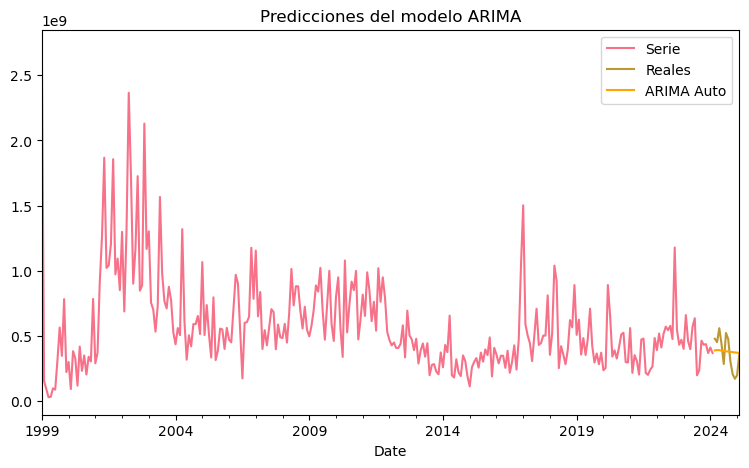

C:\Users\adria\anaconda3\Lib\site-packages\jupyter_client\session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [63]:
# Plot predictions
fig, ax = plt.subplots(figsize=(9, 5))
nvd_train["Volume"].plot(ax=ax, label='Serie')
nvd_test["Volume"].plot(ax=ax, label='Reales')
predicciones_statsmodels_fin.plot(ax=ax, label='ARIMA Auto', color="orange")
ax.set_title('Predicciones del modelo ARIMA')
ax.legend();

Nuestro modelo final es:

$$
\textbf{ARIMA(2,0,4)(0,0,0)[12]:} \quad 
Y_t = c + \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \theta_3 \epsilon_{t-3} + \theta_4 \epsilon_{t-4} + \epsilon_t
$$